C:\Users\manur\AppData\Local\Temp\ipykernel_8388\2093774885.py:109: RuntimeWarning:

Mean of empty slice

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



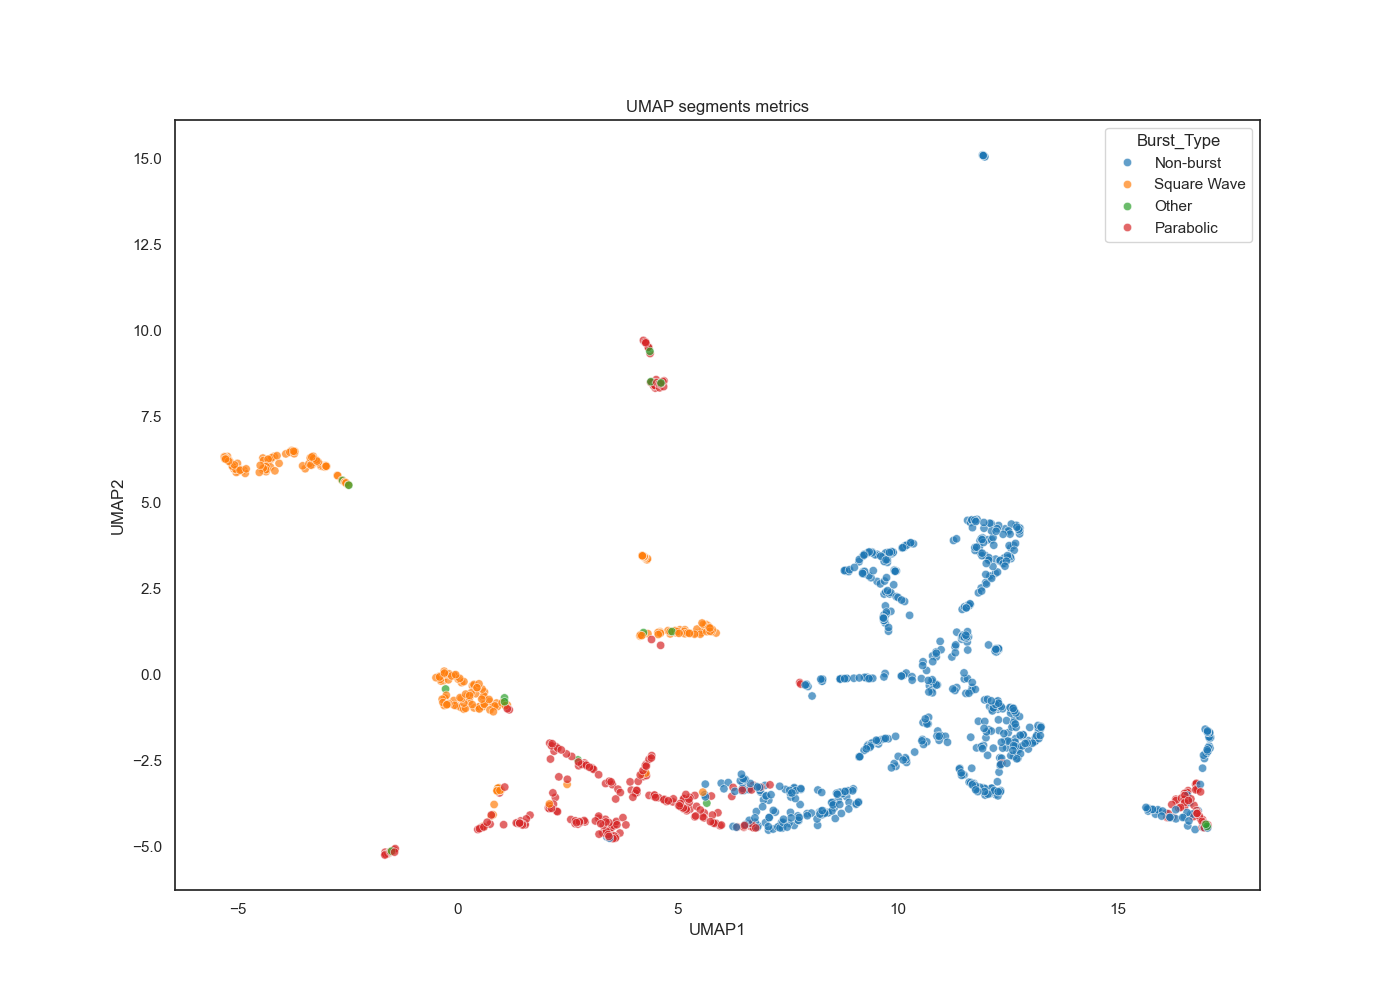

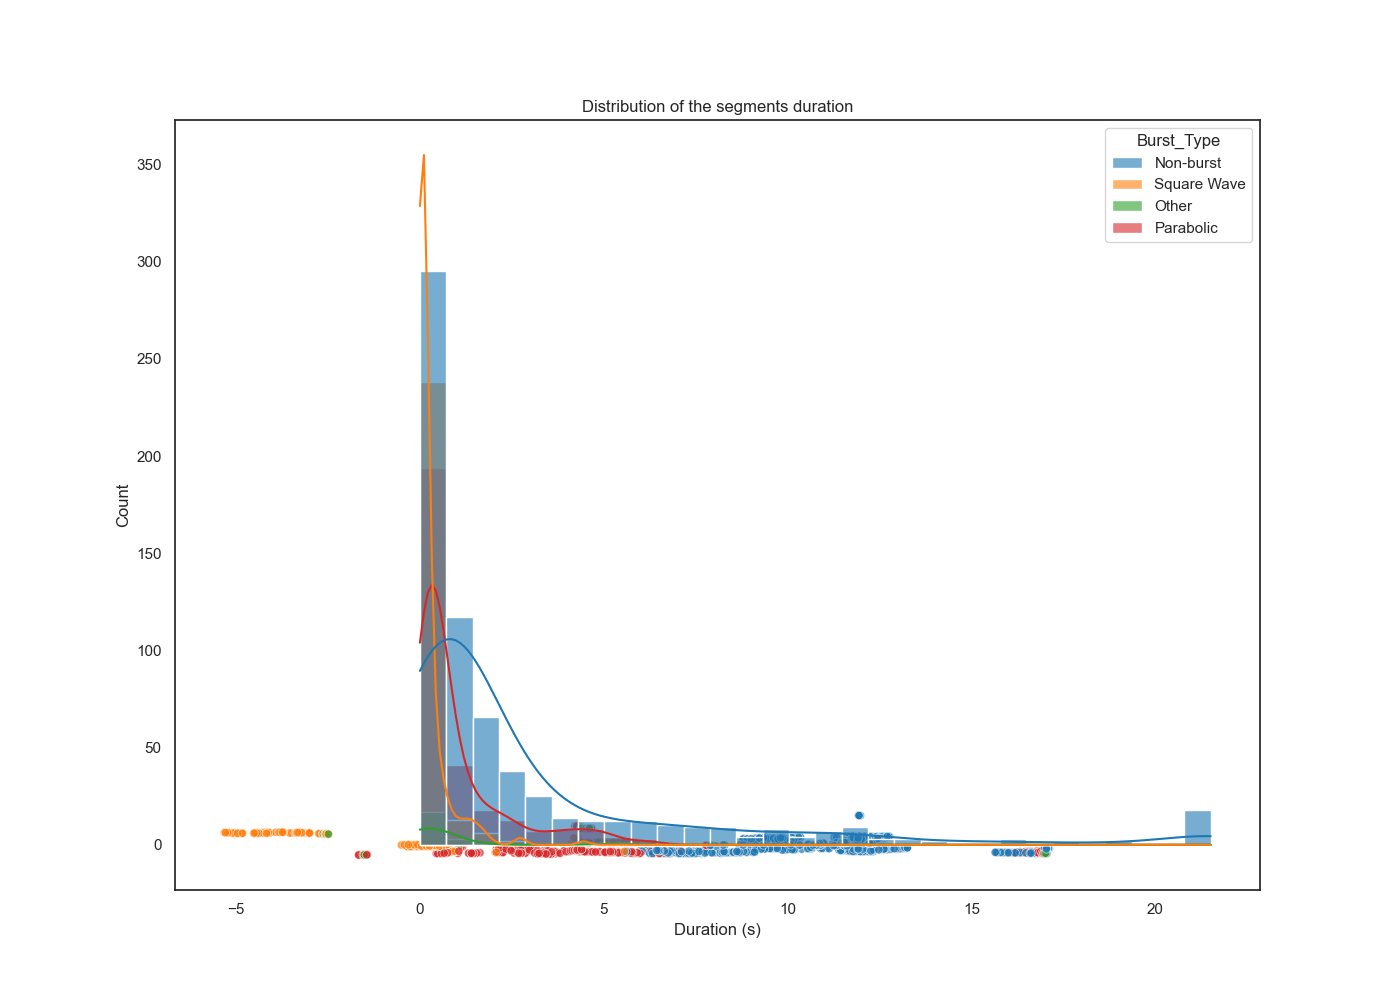

In [1]:
#Load libraries
import os                          #Work with directories and files
import pyabf                       
import numpy as np                 
import pandas as pd                
from scipy.stats import skew, kurtosis   
from scipy.signal import find_peaks      
%matplotlib widget                

#Dimensionality reduction & ML
import umap                        #UMAP for nonlinear dimensionality reduction
from sklearn.preprocessing import StandardScaler  #Scale features before UMAP

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

#It forces Plotly to display in the browser (I had problems running it)
pio.renderers.default = "browser"

#Parameters
folder_path = "bursting"   #Folder with ABF files
threshold = -35            
burst_threshold = 0.3      
fs = 10000                 
dt = 1 / fs                

all_segment_metrics = []   #This list will be used later for storing all extracted features in burst and non-burst sections

#ABF files processing
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]  #List all ABF files

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    #Loop through each sweep in the file
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX          #Time vector
        voltage = abf.sweepY       #Voltage trace

        #Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs   #Convert indices to time

        #Burst detection
        bursts = []
        if len(spike_times) >= 4:  #At least 2 spikes to define a burst
            isi = np.diff(spike_times)    #Interspike intervals
            current_burst = [spike_times[0]]

            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:   #Still inside same burst
                    current_burst.append(spike_times[i])
                else:  #If ISI is too long, the burst ends
                    if len(current_burst) > 1:    #Only valid if ≥2 spikes
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]

            #Add the last burst if valid
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))

        #Segments: bursts and non-bursts
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        if bursts:
            #Add non-burst before first burst
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            #Add non-burst between bursts
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            #Add non-burst after last burst
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            #No bursts at all, the whole trace is non-burst
            segments.append((time[0], time[-1], "Non-burst"))

        #Burst type classification
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):

            if seg_type == "Burst":
                #Segment mask and minimum voltage inside burst
                seg_mask = (time >= seg_start) & (time <= seg_end)
                burst_min = np.min(voltage[seg_mask])

                #Compute surrounding baseline (mean voltage before and after burst)
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])

                inter_mean = np.nanmean([prev_mean, next_mean])

                #Classify burst by comparing min voltage with baseline
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        #Metrics per segment
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            #Peaks inside the segment
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            #Voltage metrics
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt) #I used trapezoid instead of trapz because of a version conflict

            #Derivative metrics
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            #Save metrics
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

#DataFrame and Save results
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

#UMAP Section
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
df = pd.read_csv("segment_voltage_metrics_with_ISI_and_peaks.csv")

#Features (X) and labels (y)
header = list(df)[4:]    #numeric features start from "Duration"
X = np.array(df[header])
y = np.array(df.Burst_Type)

#Standardize features before UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#UMAP projection to 2D
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

#Save embedding to DataFrame
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y

#UMAP visualization with Seaborn
#represents the segments reduced into 2D with UMAP
sns.scatterplot(
    data=df_umap, x="UMAP1", y="UMAP2",
    hue="Burst_Type", palette="tab10", alpha=0.7
)
plt.title("UMAP segments metrics")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

#Histogram with Seaborn
#represents the distribution of the segments durations
sns.set(style="whitegrid", context="notebook", rc={'figure.figsize':(10,6)})
sns.histplot(
    data=df_segments,
    x="Duration",
    hue="Burst_Type",
    bins=30,
    kde=True,
    palette="tab10",
    alpha=0.6
)
plt.title("Distribution of the segments duration")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

#Interactive Plotly visualization
fig = px.scatter(
    df_umap, x="UMAP1", y="UMAP2",
    color="Burst_Type",
    title="UMAP"
)
pio.renderers.default = "browser"
fig.show()